In [3]:
import cv2
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from glob import glob
from tqdm import tqdm
from easydict import EasyDict
import timm
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
from torch.utils.data import Dataset, DataLoader


## augmented image label 추가

In [2]:
train_df = pd.read_csv('../data/train_df.csv')

aug_labels = glob("../data/train/aug/*")
for aug_path in aug_labels :
    label = aug_path.split("\\")[-1]
    class_name = label.split("-")[0]
    state = label.split("-")[-1]
        
    file_list = os.listdir(aug_path)
    label_list = [label] * len(file_list)
    class_list = [class_name] * len(file_list)
    state_list = [state] * len(file_list)
    
    aug_df = pd.DataFrame({'index' : [i + len(train_df) for i in range(len(file_list))],
                           'file_name' : file_list,
                           'class' : class_list,
                           'state' : state_list,
                           'label' : label_list
                          })
    train_df = pd.concat([train_df, aug_df])
    
train_df = train_df.reset_index(drop=True)

In [31]:
train_df = pd.read_csv('../data/train_df.csv')

train_df['file_name'] = list(map(lambda y :os.path.join("abcd",y), train_df['file_name']))
train_df

,index,file_name,class,state,label
0,0,abcd\10000.png,transistor,good,transistor-good
1,1,abcd\10001.png,capsule,good,capsule-good
2,2,abcd\10002.png,transistor,good,transistor-good
3,3,abcd\10003.png,wood,good,wood-good
4,4,abcd\10004.png,bottle,good,bottle-good
...,...,...,...,...,...
4272,4272,abcd\14272.png,transistor,good,transistor-good
4273,4273,abcd\14273.png,transistor,good,transistor-good
4274,4274,abcd\14274.png,grid,good,grid-good
4275,4275,abcd\14275.png,zipper,good,zipper-good


In [10]:
label_enc = {k : i for i, k in enumerate(sorted(train_df['label'].unique()))}
label_enc

{'bottle-broken_large': 0,
 'bottle-broken_small': 1,
 'bottle-contamination': 2,
 'bottle-good': 3,
 'cable-bent_wire': 4,
 'cable-cable_swap': 5,
 'cable-combined': 6,
 'cable-cut_inner_insulation': 7,
 'cable-cut_outer_insulation': 8,
 'cable-good': 9,
 'cable-missing_cable': 10,
 'cable-missing_wire': 11,
 'cable-poke_insulation': 12,
 'capsule-crack': 13,
 'capsule-faulty_imprint': 14,
 'capsule-good': 15,
 'capsule-poke': 16,
 'capsule-scratch': 17,
 'capsule-squeeze': 18,
 'carpet-color': 19,
 'carpet-cut': 20,
 'carpet-good': 21,
 'carpet-hole': 22,
 'carpet-metal_contamination': 23,
 'carpet-thread': 24,
 'grid-bent': 25,
 'grid-broken': 26,
 'grid-glue': 27,
 'grid-good': 28,
 'grid-metal_contamination': 29,
 'grid-thread': 30,
 'hazelnut-crack': 31,
 'hazelnut-cut': 32,
 'hazelnut-good': 33,
 'hazelnut-hole': 34,
 'hazelnut-print': 35,
 'leather-color': 36,
 'leather-cut': 37,
 'leather-fold': 38,
 'leather-glue': 39,
 'leather-good': 40,
 'leather-poke': 41,
 'metal_nut-ben

In [17]:
aug_transforms = A.Compose([
    A.Normalize(),
    A.Resize(224,224),
    A.OneOf([
        A.Rotate(),
        A.HorizontalFlip(),
        A.VerticalFlip()
    ], p=1),
    
    A.OneOf([
        A.Affine(p=1),
        A.GridDistortion(p=1)    
    ], p=1),
    ToTensorV2()
])

train_df= pd.read_csv('../data/aug_train_df.csv')
for file_name in train_df['file_name'] :
    img = cv2.imread(file_name)
    img = aug_transforms(image=img)['image']
    print(img.shape)

torch.Size([3, 1024, 1024])

In [40]:
timm.list_models()

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_x

In [68]:
train_df= pd.read_csv('../data/aug_train_df.csv').reset_index(drop=True)
train_imgs, valid_imgs, train_labels, valid_labels = train_test_split(list(train_df['file_name']),
                  list(train_df['label']),
                  train_size=0.9,
                  shuffle=True,
                  random_state=51,
                  stratify=list(train_df['label']))
display(len(train_imgs))
display(len(valid_imgs))
display(train_labels[:5])
display(valid_labels[:5])



7348

817

['bottle-contamination',
 'cable-combined',
 'hazelnut-hole',
 'zipper-good',
 'tile-crack']

['metal_nut-good',
 'leather-good',
 'capsule-poke',
 'zipper-fabric_interior',
 'pill-color']

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
target = torch.tensor([2,3,1,0])
input = torch.tensor([[-0.1, 0.8, 0.4, -0.5],
                     [-0.1, -0.8, 0.4, -0.5],
                     [0.1, 0.8, 0.4, -0.5],
                     [0.5, -0.8, -0.4, -0.5]])
alpha = 2
gamma = 2
ce_loss = F.cross_entropy(input, target, reduction='none')
# 작을 수록 좋음 = 1 - 확률 = negarive 느낌
display(ce_loss)

pt = torch.exp(-ce_loss)
# 클 수록 좋음 = 확률 = positive 느낌
display(pt)
floss = alpha * (1-pt)**gamma * ce_loss
# easy case 의 loss 는 높혀 주고 hard case의 loss는 낮춰줌
display(floss)


tensor([1.2542, 1.7391, 0.8918, 0.7164])

tensor([0.2853, 0.1757, 0.4099, 0.4885])

tensor([1.2812, 2.3635, 0.6210, 0.3748])

In [38]:
class FocalLoss(nn.Module) :
    def __init__(self, alpha=2, gamma=2, logits=False, reduction='none') :
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets) : #nn.CrossEntropy()
        ce_loss = nn.CrossEntropyLoss(reduction=self.reduction)(inputs, targets)
        display(ce_loss)
        pt = torch.exp(-ce_loss)
        display(pt)

        F_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        display(F_loss)

        if self.reduction :
            return torch.mean(F_loss)
        else :
            return F_loss
fl = FocalLoss()
fl(input, target)

tensor([1.2542, 1.7391, 0.8918, 0.7164])

tensor([0.2853, 0.1757, 0.4099, 0.4885])

tensor([1.2812, 2.3635, 0.6210, 0.3748])

tensor(1.1601)

(700, 700, 3)
<class 'numpy.ndarray'>


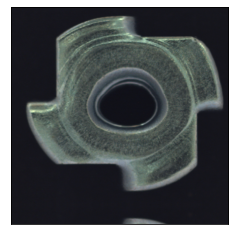

In [37]:
img_path = '../data/train\\aug_v2\\metal_nut-good\\aug_0_11150.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
print(type(img))
plt.imshow(img)
plt.xticks([]) # x축 눈금
plt.yticks([]) # y축 눈금
plt.show()

In [38]:
train_df = pd.read_csv("../data/aug_v2_train_df.csv")
train_df

,Unnamed: 0,index,file_name,class,state,label
0,0,0,../data/train\10000.png,transistor,good,transistor-good
1,1,1,../data/train\10001.png,capsule,good,capsule-good
2,2,2,../data/train\10002.png,transistor,good,transistor-good
3,3,3,../data/train\10003.png,wood,good,wood-good
4,4,4,../data/train\10004.png,bottle,good,bottle-good
...,...,...,...,...,...,...
17621,17621,17621,../data/train\aug_v2\zipper-squeezed_teeth\mix...,zipper,squeezed_teeth,zipper-squeezed_teeth
17622,17622,17622,../data/train\aug_v2\zipper-squeezed_teeth\mix...,zipper,squeezed_teeth,zipper-squeezed_teeth
17623,17623,17623,../data/train\aug_v2\zipper-squeezed_teeth\mix...,zipper,squeezed_teeth,zipper-squeezed_teeth
17624,17624,17624,../data/train\aug_v2\zipper-squeezed_teeth\mix...,zipper,squeezed_teeth,zipper-squeezed_teeth


In [4]:
class CustomDataset(Dataset):
    def __init__(self, img_list, label_list=None, transforms=None, mode="train") :
        self.img_list = img_list
        
        if mode == "train" : 
            self.label_list = self.label_encoder(label_list)
            
        self.transforms = transforms
        self.mode = mode
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        
        img = cv2.imread(img_path)
        
        try :
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except :
            print(img_path)
            print(img)
            print(img.shape)
            
        if self.transforms:            
            img = self.transforms(image=img)['image']
        
        if self.mode == "train" :
            label = self.label_list[idx]
            return img, torch.tensor(label)
        
        elif self.mode == "test" :
            return img
    
    def label_encoder(self, label_list) :
        label_enc = {k : i for i, k in enumerate(sorted(list(set(label_list))))}
        return [label_enc[label] for label in label_list]


In [5]:
opt = {
    "df_path" : "../data/aug_v2_train_df.csv",
    "save_path" : "../model/coat_mini_aug_v2_CEL",
    "model_name" : "coat_mini",
    "num_classes" : 88,
    "resize" : 224,
    "device" : "cuda:0",
    "early_stopping" : 2,
    "epochs" : 15,
    "batch_size" : 32,
    "learning_rate" : 1e-4,
    "cosine_lr_Tmax" : 20,
    "cosine_lr_eta_min" : 1e-5,
    "cutmix" : False,
    "resume" : False,
    "model_path" : "../model/coat_mini_aug_v2/4E_0.0607_coat_mini.pt"
}
opt = EasyDict(opt)
os.makedirs(opt.save_path, exist_ok=True)

t_transforms = A.Compose([
    A.Normalize(),
    A.Resize(opt.resize, opt.resize),
    A.Blur(p=0.7),
    A.Rotate(limit=(-270, 270), p=1),
    A.OneOf([
        A.HorizontalFlip(),
        A.VerticalFlip()
    ], p=1),
    ToTensorV2()
])

v_transforms = A.Compose([
    A.Normalize(),
    A.Resize(opt.resize, opt.resize),
    ToTensorV2()
])

train_df = pd.read_csv(opt.df_path)
t_imgs, v_imgs, t_labels, v_labels = train_test_split(
    list(train_df['file_name']),
    list(train_df['label']),
    train_size=0.8,
    shuffle=True,
    random_state=51,
    stratify=list(train_df['label']))


train_data = CustomDataset(t_imgs, t_labels, t_transforms)
valid_data = CustomDataset(v_imgs, v_labels, v_transforms)

train_loader = DataLoader(train_data, batch_size=opt.batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=opt.batch_size, shuffle=True)

# model = CNN(opt.model_name, opt.num_classes).to(opt.device)
    
# training(model, train_loader, valid_loader, opt)

In [ ]:
for E in range(opt.epochs) :
    print(E)
    for batch, (img, label) in enumerate(tqdm(train_loader)) :
        if batch % 50 == 0 :
            print(batch)
            print(img.shape, label.shape)
            
    for batch, (img, label) in enumerate(tqdm(valid_loader)) :
        if batch % 50 == 0 :
            print(batch)
            print(img.shape, label.shape)

0


  0%|▏                                                                                 | 1/441 [00:00<05:47,  1.27it/s]

0
torch.Size([32, 3, 224, 224]) torch.Size([32])


 12%|█████████▎                                                                       | 51/441 [00:41<05:16,  1.23it/s]

50
torch.Size([32, 3, 224, 224]) torch.Size([32])


 23%|██████████████████▎                                                             | 101/441 [01:22<04:47,  1.18it/s]

100
torch.Size([32, 3, 224, 224]) torch.Size([32])


 34%|███████████████████████████▍                                                    | 151/441 [02:03<04:05,  1.18it/s]

150
torch.Size([32, 3, 224, 224]) torch.Size([32])


 46%|████████████████████████████████████▍                                           | 201/441 [02:44<03:12,  1.24it/s]

200
torch.Size([32, 3, 224, 224]) torch.Size([32])


 57%|█████████████████████████████████████████████▌                                  | 251/441 [03:24<02:33,  1.24it/s]

250
torch.Size([32, 3, 224, 224]) torch.Size([32])


 68%|██████████████████████████████████████████████████████▌                         | 301/441 [04:04<01:52,  1.25it/s]

300
torch.Size([32, 3, 224, 224]) torch.Size([32])


 80%|███████████████████████████████████████████████████████████████▋                | 351/441 [04:46<01:12,  1.23it/s]

350
torch.Size([32, 3, 224, 224]) torch.Size([32])


 91%|████████████████████████████████████████████████████████████████████████▋       | 401/441 [05:27<00:32,  1.24it/s]

400
torch.Size([32, 3, 224, 224]) torch.Size([32])


  1%|▋                                                                                 | 1/111 [00:00<01:23,  1.31it/s]

0
torch.Size([32, 3, 224, 224]) torch.Size([32])


 46%|█████████████████████████████████████▏                                           | 51/111 [00:39<00:46,  1.30it/s]

50
torch.Size([32, 3, 224, 224]) torch.Size([32])


 91%|████████████████████████████████████████████████████████████████████████▊       | 101/111 [01:18<00:07,  1.31it/s]

100
torch.Size([32, 3, 224, 224]) torch.Size([32])


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:25<00:00,  1.29it/s]


1


  0%|▏                                                                                 | 1/441 [00:00<05:41,  1.29it/s]

0
torch.Size([32, 3, 224, 224]) torch.Size([32])


 12%|█████████▎                                                                       | 51/441 [00:41<05:17,  1.23it/s]

50
torch.Size([32, 3, 224, 224]) torch.Size([32])


 23%|██████████████████▎                                                             | 101/441 [01:22<04:31,  1.25it/s]

100
torch.Size([32, 3, 224, 224]) torch.Size([32])


 34%|███████████████████████████▍                                                    | 151/441 [02:02<03:49,  1.26it/s]

150
torch.Size([32, 3, 224, 224]) torch.Size([32])


 46%|████████████████████████████████████▍                                           | 201/441 [02:41<03:13,  1.24it/s]

200
torch.Size([32, 3, 224, 224]) torch.Size([32])


 57%|█████████████████████████████████████████████▌                                  | 251/441 [03:21<02:32,  1.24it/s]

250
torch.Size([32, 3, 224, 224]) torch.Size([32])


 68%|██████████████████████████████████████████████████████▌                         | 301/441 [04:02<01:57,  1.19it/s]

300
torch.Size([32, 3, 224, 224]) torch.Size([32])


 80%|███████████████████████████████████████████████████████████████▋                | 351/441 [04:44<01:15,  1.20it/s]

350
torch.Size([32, 3, 224, 224]) torch.Size([32])


 91%|████████████████████████████████████████████████████████████████████████▋       | 401/441 [05:25<00:33,  1.21it/s]

400
torch.Size([32, 3, 224, 224]) torch.Size([32])


  1%|▋                                                                                 | 1/111 [00:00<01:27,  1.26it/s]

0
torch.Size([32, 3, 224, 224]) torch.Size([32])


 46%|█████████████████████████████████████▏                                           | 51/111 [00:39<00:46,  1.30it/s]

50
torch.Size([32, 3, 224, 224]) torch.Size([32])


 91%|████████████████████████████████████████████████████████████████████████▊       | 101/111 [01:18<00:07,  1.28it/s]

100
torch.Size([32, 3, 224, 224]) torch.Size([32])


100%|████████████████████████████████████████████████████████████████████████████████| 111/111 [01:25<00:00,  1.29it/s]


2


  0%|▏                                                                                 | 1/441 [00:00<05:31,  1.33it/s]

0
torch.Size([32, 3, 224, 224]) torch.Size([32])


 12%|█████████▎                                                                       | 51/441 [00:42<05:18,  1.22it/s]

50
torch.Size([32, 3, 224, 224]) torch.Size([32])


 23%|██████████████████▎                                                             | 101/441 [01:23<04:40,  1.21it/s]

100
torch.Size([32, 3, 224, 224]) torch.Size([32])


 32%|█████████████████████████▏                                                      | 139/441 [01:54<04:07,  1.22it/s]

In [7]:
11 % 10

1